# Case g.c2b6.GJRA.TL319_t061.long_JRA_mct.061 

Compset longname is 2000_DATM%JRA_SLND_CICE_MOM6_DROF%JRA_SGLC_SWAV_SIAC_SESP

* AH=1E12
* LEITH_AH = True
* LEITH_BI_CONST = 128.0
* MEKE = True
* MEKE_VISCOSITY_COEFF_AU = 0.0
* MEKE_GEOMETRIC_ALPHA = 0.07

Gustavo Marques (gmarques@ucar.edu)

In [1]:
from datetime import date
print("Last update:", date.today())

Last update: 2020-04-30


## Globally-averaged ocean properties

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
path = '/glade/scratch/gmarques/'
exps = ['g.c2b6.GJRA.TL319_t061.long_JRA_mct.061']
labels = ['G61']

def get_data(full_path, variables):
  def preprocess(ds):
    ''' Return the dataset with variable'''
    return ds[variables]
  ds = xr.open_mfdataset(full_path, data_vars='minimal', \
                         coords='minimal', compat='override', preprocess=preprocess)
  return ds

import seaborn, matplotlib
matplotlib.rcParams.update({'font.size': 14})

In [4]:
# load pre-difined masks
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6toolbox import genBasinMasks
from mom6_tools.m6plot import ztplot, polarplot, xyplot, xycompare, yzplot
import pop_tools
import cartopy.crs as ccrs
import cartopy.feature
grd = MOM6grid('/glade/scratch/gmarques/'+str(exps[0])+'/run/'+str(exps[0])+'.mom6.static.nc')
depth = grd.depth_ocean
# remote Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, xda=True)
grid = pop_tools.get_grid('POP_gx1v7')

Basemap module not found. Some regional plots may not function properly


Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


MOM6 grid successfully loaded... 

11.16427964664149 64.78854837178643 [391, 434]


/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.061/run/*mom6.hm_*_01.nc


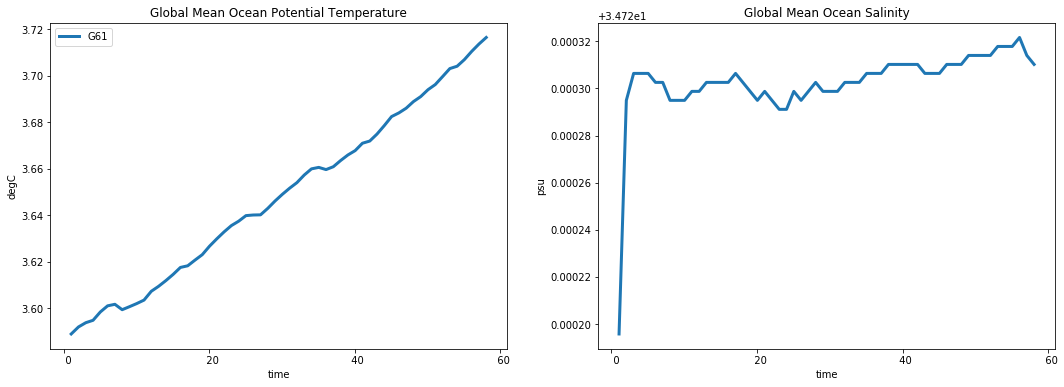

In [5]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
variables = ['thetaoga', 'soga']
for i in range(len(exps)):
  # reading just January data
  tmp = path+exps[i]+'/run/*mom6.hm_*_01.nc'
  print(tmp)
  ds = get_data(tmp,variables)
  ds1 = ds.sel(time=slice('0001-01-01', '0059-01-01'))
  ds1['thetaoga'].plot(ax=ax[0], label=labels[i], lw=3)
  ds1['soga'].plot(ax=ax[1], lw=3)

ax[0].set_title(ds1.thetaoga.attrs['long_name']); ax[0].set_ylabel(ds1.thetaoga.attrs['units'])
ax[1].set_title(ds1.soga.attrs['long_name']); ax[1].set_ylabel(ds1.soga.attrs['units']); ax[0].legend()

/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.061/run/ocean.stats.nc


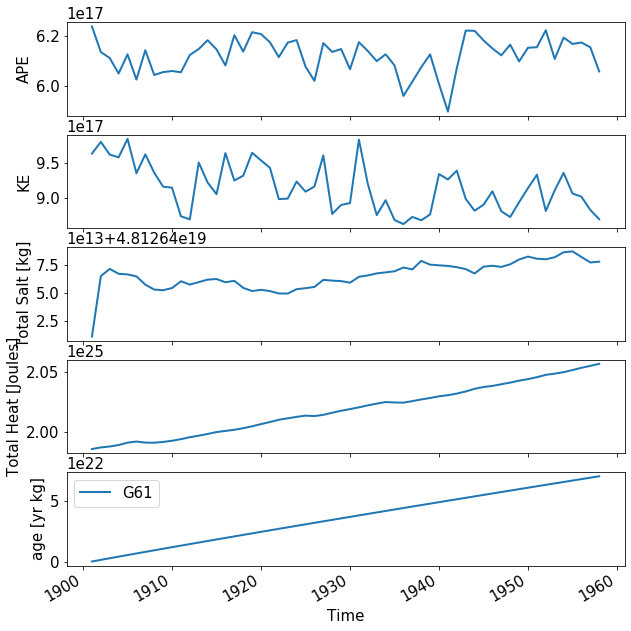

In [6]:
plt.rcParams.update({'font.size': 15})
variables = ['APE', 'KE', 'Salt', 'Heat', 'age']
fig, ax = plt.subplots(nrows=len(variables), ncols=1, figsize=(10,10), sharex=True)
for i in range(len(exps)): 
  path_to_file = path+exps[i]+'/run/ocean.stats.nc'
  print(path_to_file)
  ds = xr.open_dataset(path_to_file)
  time = pd.date_range('1900-01-01', periods=len(ds.Time), freq='D')

  ds['Time'] = time[:]  
  ds1 = ds.resample(Time="1Y", closed='left', keep_attrs=True).mean(dim='Time', keep_attrs=True)   
  ds2 = ds1.sel(Time=slice('1900-01-01', '1980-01-01'))
  for var, j in zip(variables, range(len(variables))):
    if len(ds2[var].shape) > 1:
        tmp = ds2[var].sum(axis=1)
    else:
        tmp = ds2[var]
    tmp.plot(ax=ax[j], label=labels[i], lw=2)
    ax[j].set_xlabel('')
    
ax[j].set_xlabel('Time'); ax[j].legend()

## Mixed layer depth

In [7]:
filepath = '/glade/work/gmarques/cesm/datasets/MLD/deBoyer/deBoyer_MLD_remapped_to_tx06v1.nc'
print('\n Reading climatology from: ', filepath)
mld_obs = xr.open_dataset(filepath)
months = [0,1,2]
obs_JFM = np.ma.masked_invalid(mld_obs.mld.isel(time=months).mean('time').values)
months = [6,7,8]
obs_JAS = np.ma.masked_invalid(mld_obs.mld.isel(time=months).mean('time').values)
obs_winter = obs_JAS.copy(); obs_summer = obs_JAS.copy()
j = np.abs( grd.geolat[:,0] - 0. ).argmin()
obs_winter[j::,:] = obs_JFM[j::,:]
obs_summer[0:j,:] = obs_JFM[0:j,:]

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
def add_labels(ax, nh='JFM', sh='JAS'):
    ax.plot([grd.geolon[0,0], grd.geolon[0,-1]], [0,0], 'k--', lw=0.5)
    ax.text(25, 7, nh, ha="center", va="center", size=12, bbox=bbox_props)
    ax.text(25, -7, sh, ha="center", va="center", size=12, bbox=bbox_props)


 Reading climatology from:  /glade/work/gmarques/cesm/datasets/MLD/deBoyer/deBoyer_MLD_remapped_to_tx06v1.nc


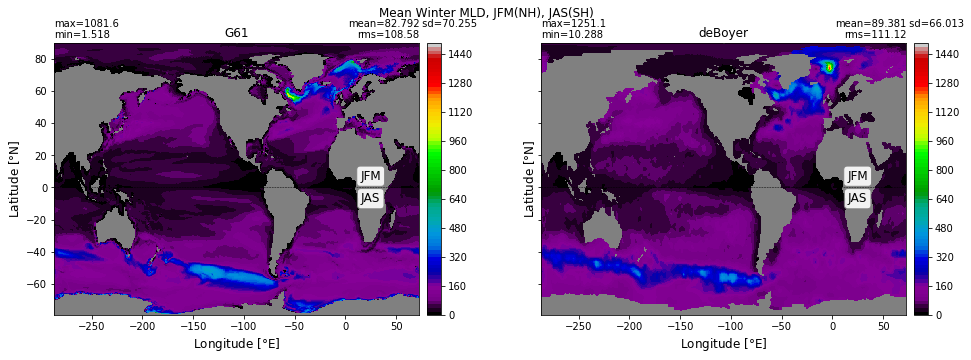

In [8]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5), sharex=True, sharey=True)
ax1 = ax.flatten()
plt.suptitle('Mean Winter MLD, JFM(NH), JAS(SH)')
for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_MLD_winter.nc')
  if i == 0:
   control = np.ma.masked_invalid(ds.MLD_winter.values)
   xyplot(control, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i], clim=(0,1500), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i])
  else:
   var = np.ma.masked_invalid(ds.MLD_winter.values) 
   xyplot(var, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i+1], clim=(0,1500),
         colormap=plt.cm.nipy_spectral, nbins=100); add_labels(ax1[i+1])

xyplot(obs_winter, grd.geolon, grd.geolat, grd.area_t, title='deBoyer', axis=ax1[1], clim=(0,1500), nbins=100,
       colormap=plt.cm.nipy_spectral); add_labels(ax1[1])

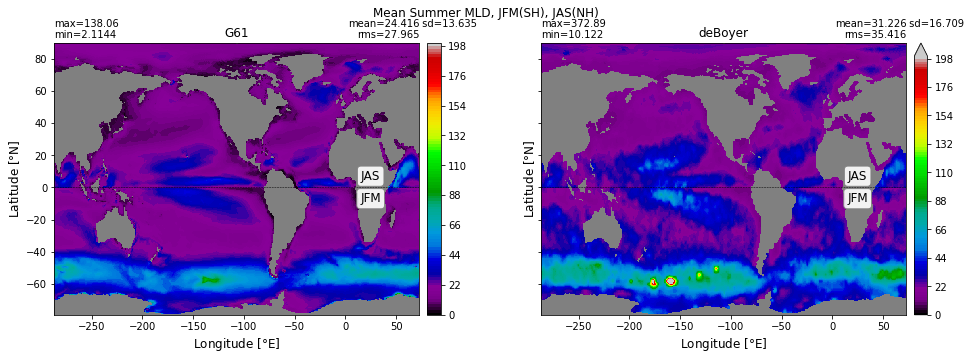

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5), sharex=True, sharey=True)
ax1 = ax.flatten()
plt.suptitle('Mean Summer MLD, JFM(SH), JAS(NH)')
for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_MLD_summer.nc')
  if i == 0:
   control = np.ma.masked_invalid(ds.MLD_summer.values)
   xyplot(control, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i], clim=(0,200), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i], sh='JFM', nh='JAS')
  else:
   var = np.ma.masked_invalid(ds.MLD_summer.values) 
   xyplot(var, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i+1], clim=(0,200), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i+1], sh='JFM', nh='JAS')

xyplot(obs_summer, grd.geolon, grd.geolat, grd.area_t, title='deBoyer', axis=ax1[1], clim=(0,200), nbins=100,
       colormap=plt.cm.nipy_spectral); add_labels(ax1[1], sh='JFM', nh='JAS')

## Poleward Heat Transport

</center>
<table>
<tr>
<td><img   src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.061_HeatTransport_global.png'></td>
</tr><tr>
<td><img   src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.061_HeatTransport_Atlantic.png'></td>
</tr><tr>
<td><img   src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.061_HeatTransport_IndoPacific.png'></td>
</tr>
</table>


## Meridional Overturning Circulation

<center> <font size="4">Global</font>
 </center>
<table><tr><td><img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.061_MOC_global.png'></td>
</tr>
</table>

<center> <font size="4">Atlantic</font></center>
<table><tr><td><img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.061_MOC_Atlantic.png'></td>
</tr>
</table>

<center> <font size="4">Global GM and FFH</font></center>
<table><tr>
<td><img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.061_GM_MOC_global.png'></td>
<td><img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.061_FFH_MOC_global.png'></td>
</tr>
</table>

#### Profile @ 26N

<table>
    <tr>
    <td><img   src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.061_MOC_profile_26N.png'></td>
    </tr>   
</table>

#### MOC GM time series between -65 and -30 degN

Text(0.5, 1.0, ' MOC GM, extreme value between -65 and -30 degN')

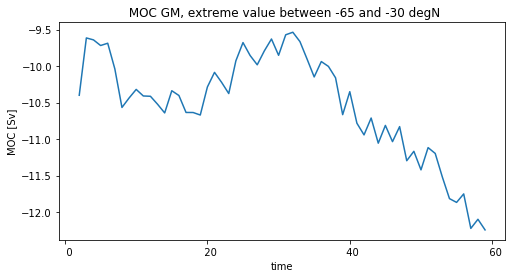

In [46]:
gm_moc = xr.open_dataset('../../'+exps[0]+'/ncfiles/'+exps[0]+'_MOC_GM_time_series.nc').rename({'__xarray_dataarray_variable__':'MOC'})
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
gm_moc.MOC.plot(ax=ax)
ax.set_ylabel('MOC [Sv]')
ax.set_title(' MOC GM, extreme value between -65 and -30 degN')

#### AMOC time series @ 26N and 45N

<table>
    <tr>
    <td><img   src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.061_MOC_26N_time_series.png'></td>
    </tr>
    <tr>
    <td><img   src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.061_MOC_45N_time_series.png'></td>
    </tr>    
</table>

## Transports

<table>
    <tr>
    <td><img   src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.061_section_transports.png'></td>
    </tr>  
</table>

## T/S bias at selected vertical levels

In [11]:
# load PHC2 data
phc_path = '/glade/p/cesm/omwg/obs_data/phc/'
phc_temp_mom = xr.open_mfdataset(phc_path+'PHC2_TEMP_tx0.66v1_34lev_ann_avg.nc', 
                             decode_coords=False, decode_times=False)
phc_salt_mom = xr.open_mfdataset(phc_path+'PHC2_SALT_tx0.66v1_34lev_ann_avg.nc', 
                             decode_coords=False, decode_times=False)

phc_temp_pop = xr.open_dataset(phc_path+'PHC2_TEMP_gx1v7_60lev_ann_avg.nc', 
                             decode_coords=False, decode_times=False)
phc_salt_pop = xr.open_dataset(phc_path+'PHC2_SALT_gx1v7_60lev_ann_avg.nc', 
                             decode_coords=False, decode_times=False)

In [12]:
def find_nearest(array, value):
    '''Find nearest value and return its indice'''
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

#### Temperature

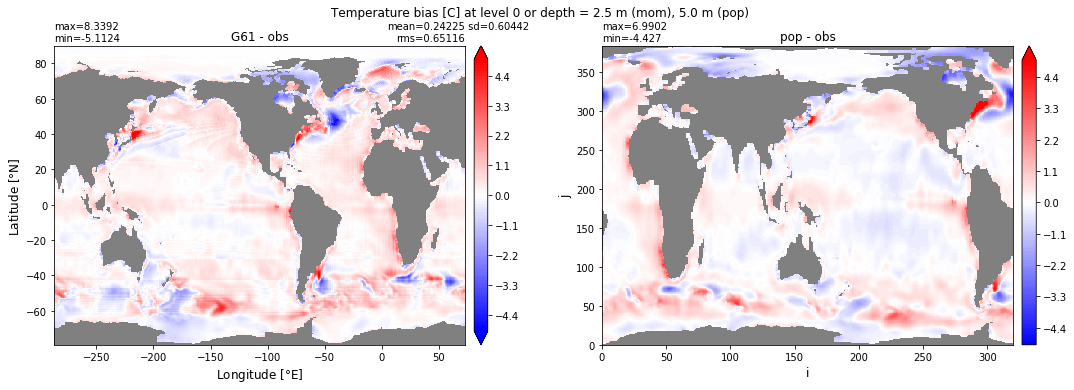

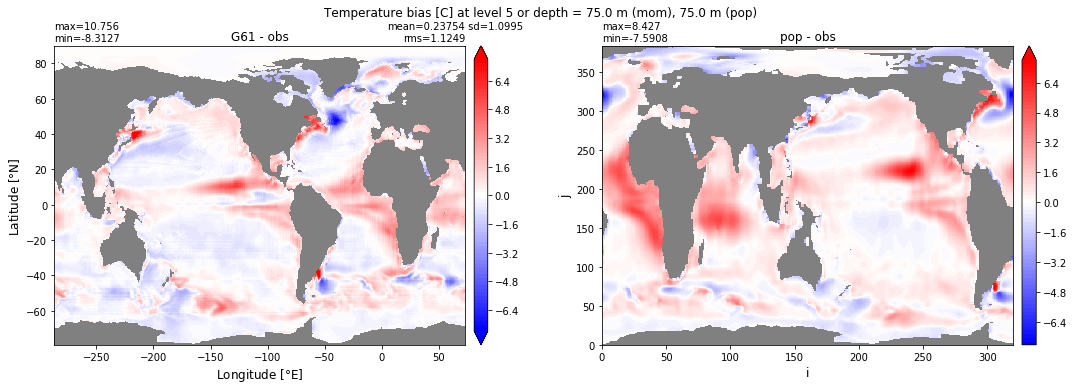

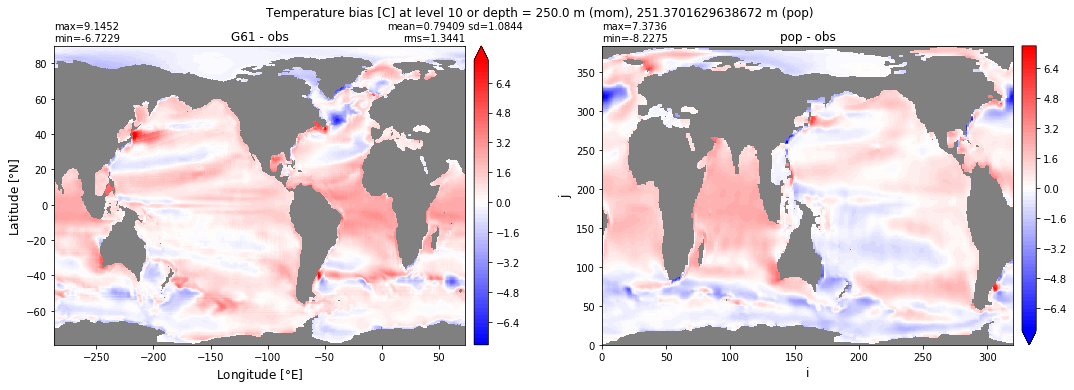

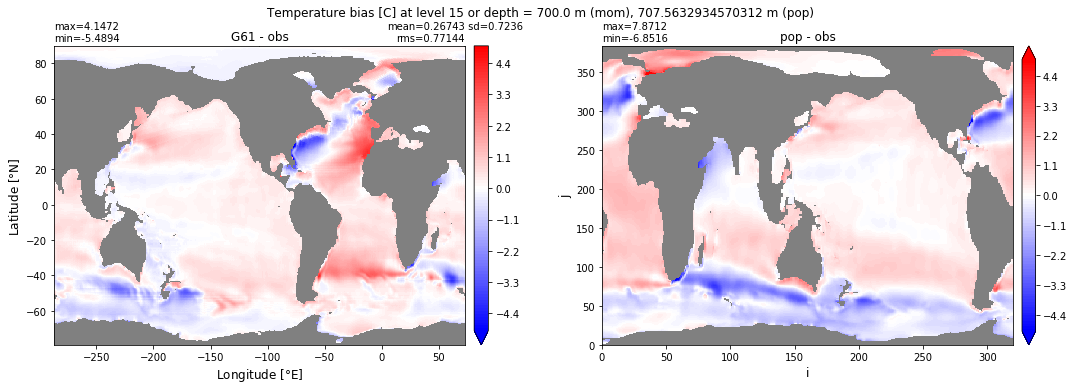

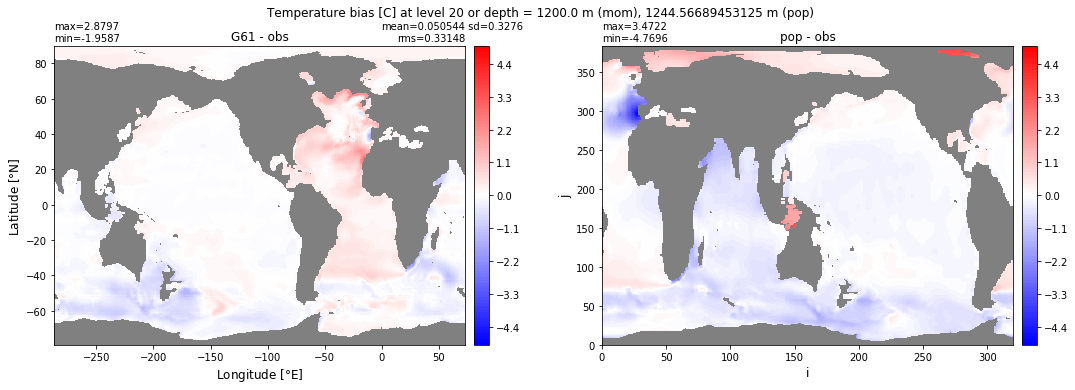

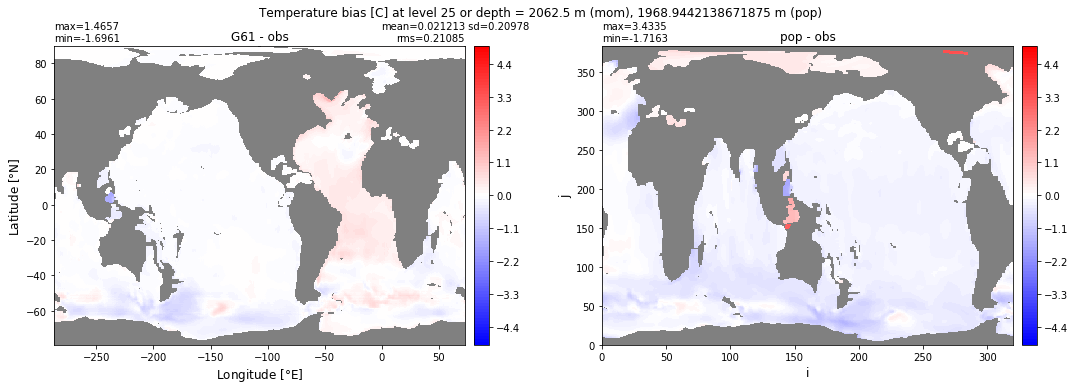

In [13]:
%matplotlib inline
# change k indice to see bias at other depths
levels=[0,5,10,15,20,25]
ds_mom_t = xr.open_dataset('../../'+exps[0]+'/ncfiles/'+exps[0]+'_thetao_time_mean.nc')
ds_pop_t = xr.open_dataset('/glade/scratch/gmarques/g210.GIAF_JRA.v13.gx1v7.01_thetao_time_mean.nc')
tlim=[5,7.5,7.5,5,5,5]
for k,t in zip(levels,tlim):
  kpop =  find_nearest(phc_salt_pop.depth.values,phc_temp_mom.depth[k].values) 
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,5.5))
  ax1 = ax.flatten()
  temp_mom = np.ma.masked_invalid(ds_mom_t.thetao[k,:].values)
  temp_mom_obs = np.ma.masked_invalid(phc_temp_mom['TEMP'][k,:].values)
  temp_pop = np.ma.masked_invalid(ds_pop_t.thetao[kpop,:].values)
  temp_pop_obs = np.ma.masked_invalid(phc_temp_pop['TEMP'][kpop,:].values)
  plt.suptitle('Temperature bias [C] at level {} or depth = {} m (mom), {} m (pop)'.format(k, 
               phc_temp_mom.depth[k].values, phc_temp_pop.depth[kpop].values))
  xyplot(temp_mom-temp_mom_obs, grd.geolon, grd.geolat, grd.area_t, title=str(labels[0]+' - obs'), axis=ax1[0], 
         clim=(-t,t), nbins=100, colormap=plt.cm.bwr, centerlabels=True)
  xyplot(temp_pop-temp_pop_obs, title=str('pop - obs'), axis=ax1[1], 
         clim=(-t,t), nbins=100, colormap=plt.cm.bwr, centerlabels=True)


#### Salinity

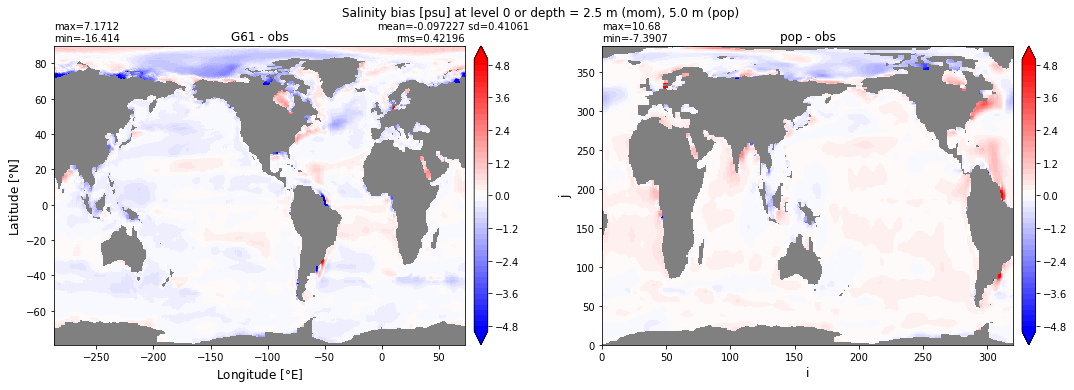

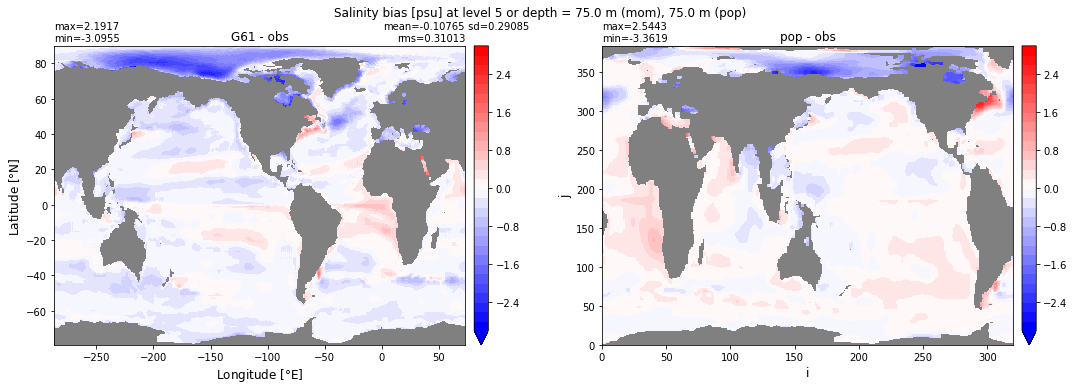

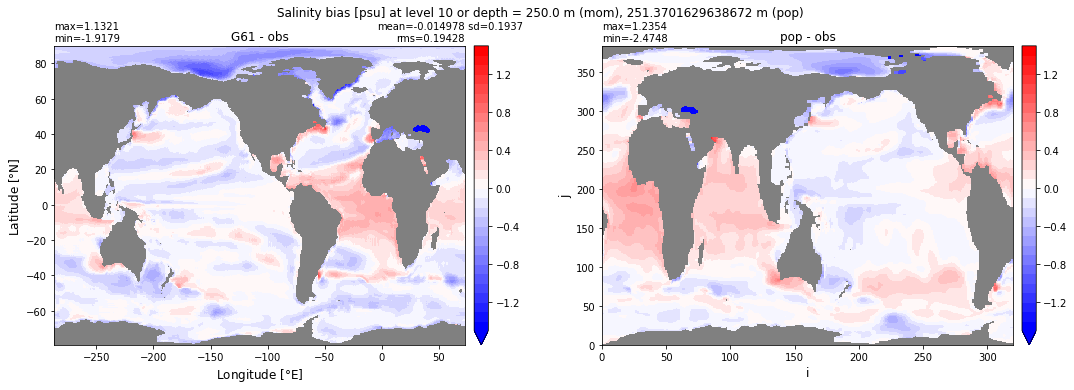

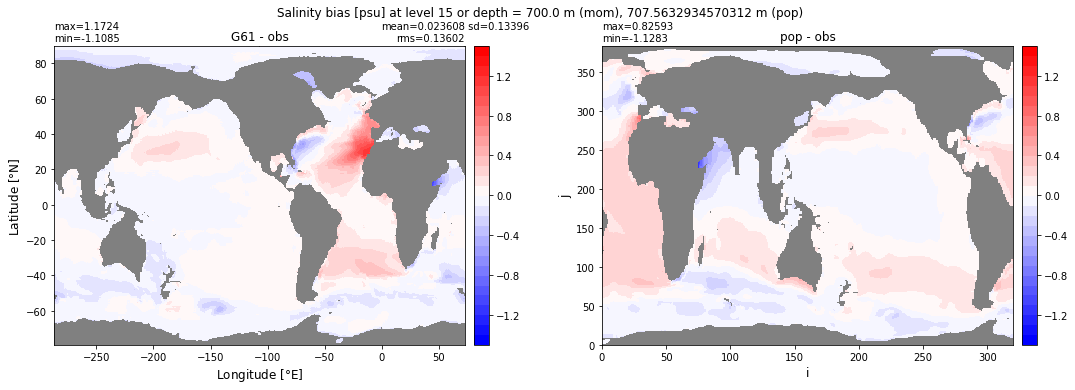

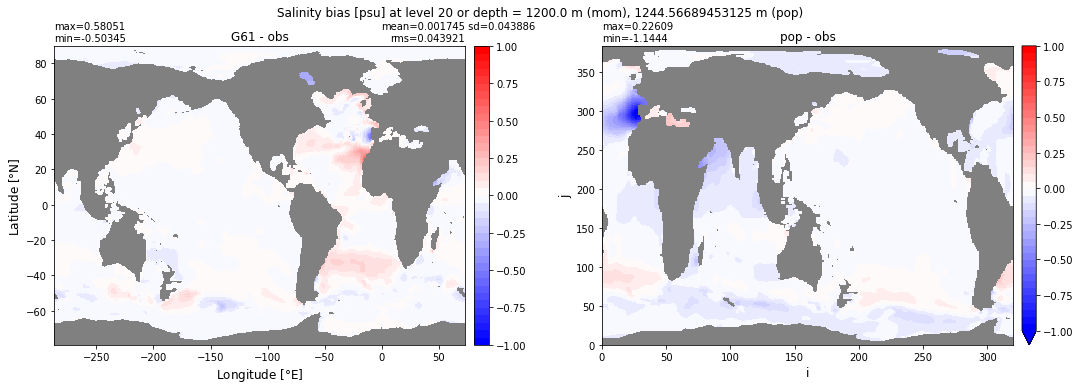

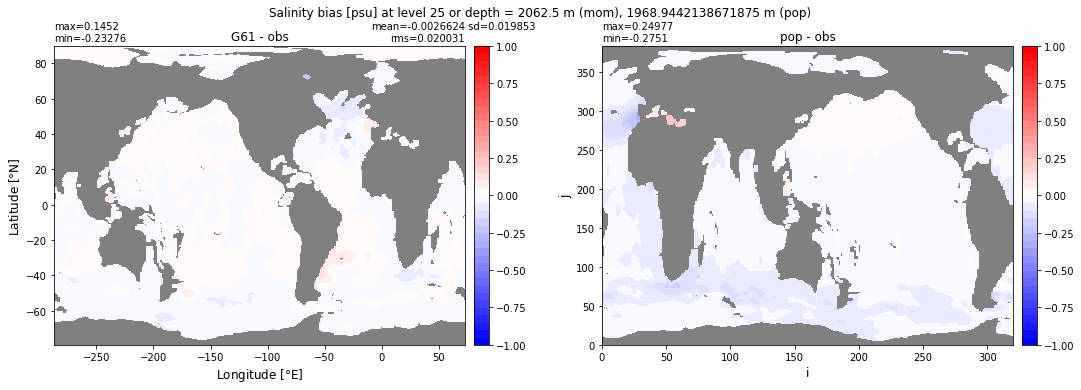

In [14]:
%matplotlib inline
# change k indice to see bias at other depths
levels=[0,5,10,15,20,25]
ds_mom_s = xr.open_dataset('../../'+exps[0]+'/ncfiles/'+exps[0]+'_so_time_mean.nc')
ds_pop_s = xr.open_dataset('/glade/scratch/gmarques/g210.GIAF_JRA.v13.gx1v7.01_so_time_mean.nc')
slim=[5,3,1.5,1.5,1,1]
for k,s in zip(levels,slim):
  kpop =  find_nearest(phc_salt_pop.depth.values,phc_temp_mom.depth[k].values)  
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,5.5))
  ax1 = ax.flatten()
  salt_mom = np.ma.masked_invalid(ds_mom_s.so[k,:].values)
  salt_mom_obs = np.ma.masked_invalid(phc_salt_mom['SALT'][k,:].values)
  salt_pop = np.ma.masked_invalid(ds_pop_s.so[kpop,:].values)
  salt_pop_obs = np.ma.masked_invalid(phc_salt_pop['SALT'][kpop,:].values)
  plt.suptitle('Salinity bias [psu] at level {} or depth = {} m (mom), {} m (pop)'.format(k, 
               phc_salt_mom.depth[k].values, phc_salt_pop.depth[kpop].values))
  xyplot(salt_mom-salt_mom_obs, grd.geolon, grd.geolat, grd.area_t, title=str(labels[0]+' - obs'), axis=ax1[0], 
         clim=(-s,s), nbins=50, colormap=plt.cm.bwr, centerlabels=True)
  xyplot(salt_pop-salt_pop_obs, title=str('pop - obs'), axis=ax1[1], 
         clim=(-s,s), nbins=50, colormap=plt.cm.bwr, centerlabels=True)

# Zonally averaged T/S Bias  

### Global

In [15]:
# POP
# reconstruct interfaces
elev_pop = np.concatenate([0,np.diff(ds_pop_t.z_l/100.).cumsum(),6000.], axis=None)
[_, z_pop] = np.meshgrid(grid.TLAT.mean('nlon').values, -elev_pop)
pop_temp_bias = xr.DataArray((ds_pop_t.thetao.values) - (phc_temp_pop.TEMP.values), dims=('z_l', 'yh','xh'), 
                             coords={'z_l':ds_pop_t.z_l, 'yh': ds_pop_t.yh, 'xh':ds_pop_t.xh})
pop_salt_bias = xr.DataArray((ds_pop_s.so.values) - (phc_salt_pop.SALT.values), dims=('z_l', 'yh','xh'), 
                             coords={'z_l':ds_pop_t.z_l, 'yh': ds_pop_t.yh, 'xh':ds_pop_t.xh})
area_pop = grid.TAREA.where(grid.KMT > 0).rename({'nlat':'yh', 'nlon':'xh'})

In [16]:
# MOM
# reconstruct interfaces
elev_mom = np.concatenate([0,np.diff(ds_mom_t.z_l).cumsum(),6000.], axis=None)
[_, z_mom] = np.meshgrid(ds_mom_t.yh.values, -elev_mom)

mom_temp_bias = xr.DataArray((ds_mom_t.thetao.values) - (phc_temp_mom.TEMP.values), dims=('z_l', 'yh','xh'), 
                             coords={'z_l':ds_mom_t.z_l, 'yh': ds_mom_t.yh, 'xh':ds_mom_t.xh})
mom_salt_bias = xr.DataArray((ds_mom_s.so.values) - (phc_salt_mom.SALT.values), dims=('z_l', 'yh','xh'), 
                             coords={'z_l':ds_mom_t.z_l, 'yh': ds_mom_t.yh, 'xh':ds_mom_t.xh})
area_mom = xr.DataArray(np.ma.masked_where(grd.wet == 0,grd.area_t), dims=('yh','xh'), coords={'yh': ds_mom_t.yh, 'xh':ds_mom_t.xh})

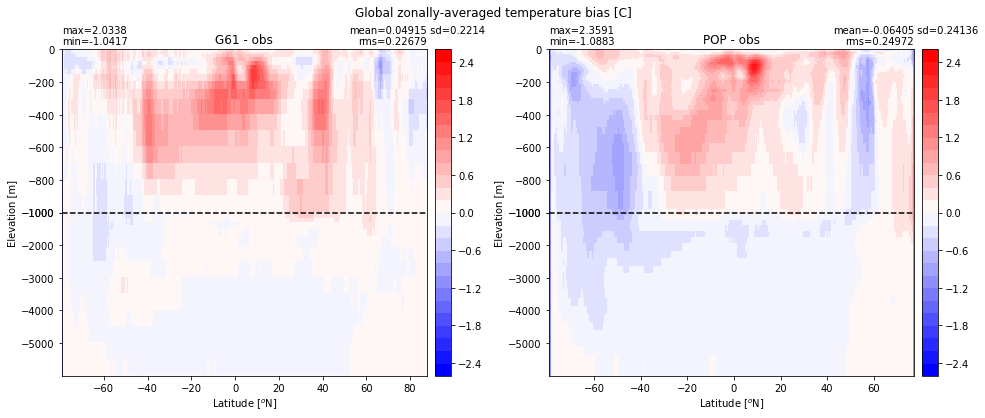

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Global zonally-averaged temperature bias [C]')
mom_temp_global = ((mom_temp_bias * area_mom).sum('xh')/area_mom.sum('xh'))
pop_temp_global = ((pop_temp_bias * area_pop).sum('xh')/area_pop.sum('xh'))

yzplot(np.ma.masked_invalid(mom_temp_global), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-2.5, 2.5), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[0].invert_yaxis()

yzplot(np.ma.masked_invalid(pop_temp_global), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$N', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-2.5,2.5), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[1].invert_yaxis()

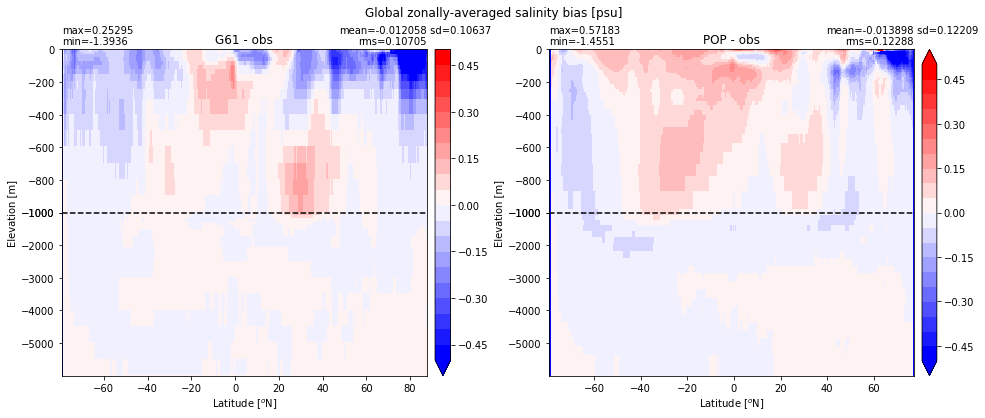

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Global zonally-averaged salinity bias [psu]')
mom_salt_global = ((mom_salt_bias * area_mom).sum('xh')/area_mom.sum('xh'))
pop_salt_global = ((pop_salt_bias * area_pop).sum('xh')/area_pop.sum('xh'))

yzplot(np.ma.masked_invalid(mom_salt_global), ds_mom_s.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-0.5, 0.5), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[0].invert_yaxis()
yzplot(np.ma.masked_invalid(pop_salt_global), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$N', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-0.5, 0.5), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[1].invert_yaxis()

### Atlantic

In [19]:
# POP
# mask #6
mask_pop_atl = (grid.REGION_MASK.where(grid.REGION_MASK==6)/6.).rename({'nlon': 'xh','nlat': 'yh'})
pop_temp_alt = ((pop_temp_bias * area_pop * mask_pop_atl).sum('xh')/area_pop.sum('xh'))
pop_salt_alt = ((pop_salt_bias * area_pop * mask_pop_atl).sum('xh')/area_pop.sum('xh'))

# MOM
mom_temp_alt = ((basin_code.sel(region='AtlanticOcean')*mom_temp_bias * area_mom).sum('xh')/area_mom.sum('xh'))
mom_salt_alt = ((basin_code.sel(region='AtlanticOcean')*mom_salt_bias * area_mom).sum('xh')/area_mom.sum('xh'))

(-41, 75)

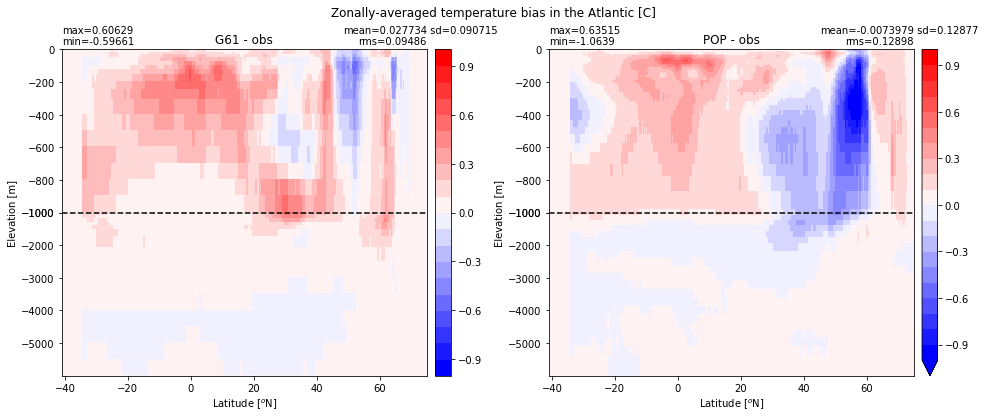

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Zonally-averaged temperature bias in the Atlantic [C]')
yzplot(np.ma.masked_invalid(mom_temp_alt.transpose()), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-1, 1), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(-41,75)
yzplot(np.ma.masked_invalid(pop_temp_alt), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$N', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-1,1), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(-41,75)

(-41, 75)

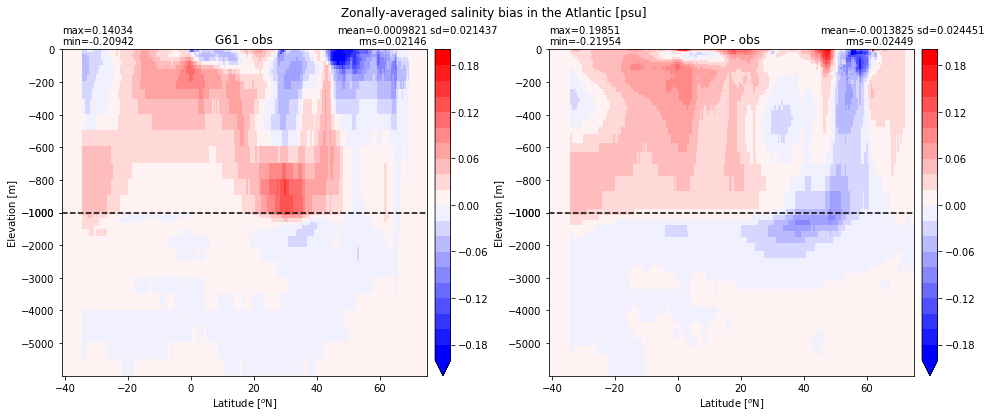

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Zonally-averaged salinity bias in the Atlantic [psu]')

yzplot(np.ma.masked_invalid(mom_salt_alt.transpose()), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-0.2, 0.2), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(-41,75)
yzplot(np.ma.masked_invalid(pop_salt_alt), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$N', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-0.2, 0.2), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(-41,75)

### Pacific

In [22]:
# POP
# mask #2
mask_pop_pac = (grid.REGION_MASK.where(grid.REGION_MASK==2)/2.).rename({'nlon': 'xh','nlat': 'yh'})
pop_temp_pac = ((pop_temp_bias * area_pop * mask_pop_pac).sum('xh')/area_pop.sum('xh'))
pop_salt_pac = ((pop_salt_bias * area_pop * mask_pop_pac).sum('xh')/area_pop.sum('xh'))

# MOM
mom_temp_pac = ((basin_code.sel(region='PacificOcean')*mom_temp_bias * area_mom).sum('xh')/area_mom.sum('xh'))
mom_salt_pac = ((basin_code.sel(region='PacificOcean')*mom_salt_bias * area_mom).sum('xh')/area_mom.sum('xh'))

(-41, 62)

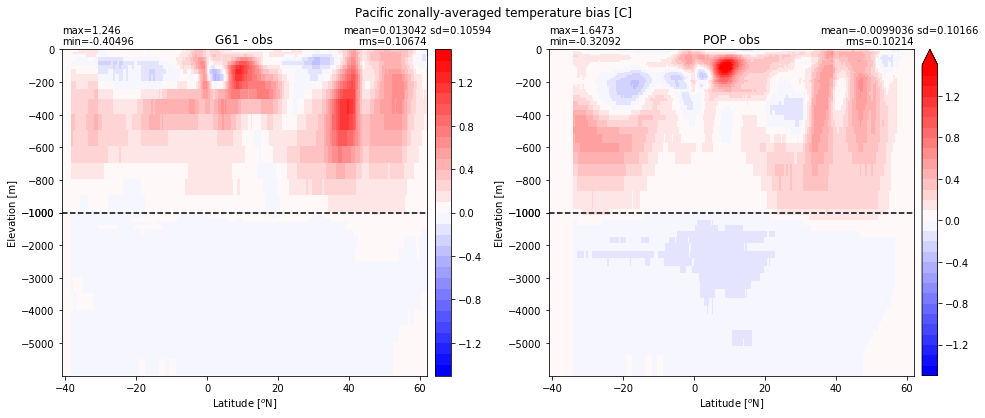

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Pacific zonally-averaged temperature bias [C]')
yzplot(np.ma.masked_invalid(mom_temp_pac.transpose()), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-1.5, 1.5), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(-41,62)
yzplot(np.ma.masked_invalid(pop_temp_pac), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$N', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-1.5,1.5), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(-41,62)

(-41, 62)

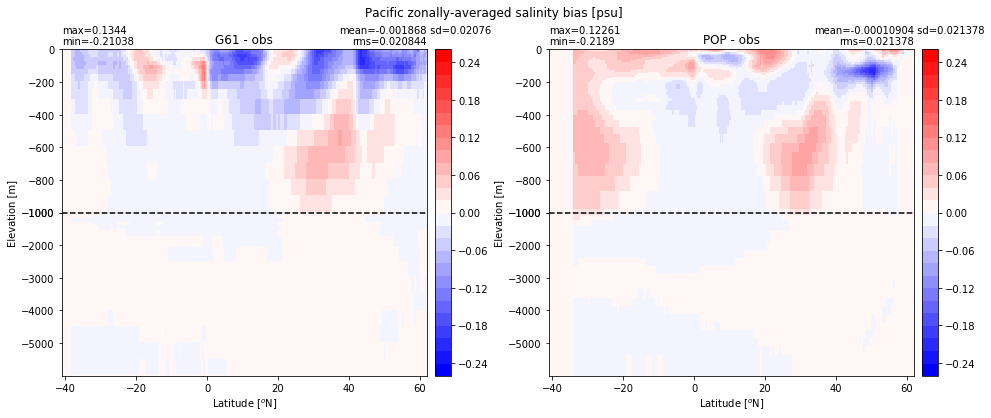

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Pacific zonally-averaged salinity bias [psu]')
yzplot(np.ma.masked_invalid(mom_salt_pac.transpose()), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-0.25, 0.25), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(-41,62)
yzplot(np.ma.masked_invalid(pop_salt_pac), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$N', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-0.25, 0.25), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(-41,62)

### Southern Ocean

In [25]:
# POP
# mask #1
mask_pop_so = (grid.REGION_MASK.where(grid.REGION_MASK==1)).rename({'nlon': 'xh','nlat': 'yh'})
pop_temp_so = ((pop_temp_bias * area_pop * mask_pop_so).sum('xh')/area_pop.sum('xh'))
pop_salt_so = ((pop_salt_bias * area_pop * mask_pop_so).sum('xh')/area_pop.sum('xh'))

# MOM
mom_temp_so = ((basin_code.sel(region='SouthernOcean')*mom_temp_bias * area_mom).sum('xh')/area_mom.sum('xh'))
mom_salt_so = ((basin_code.sel(region='SouthernOcean')*mom_salt_bias * area_mom).sum('xh')/area_mom.sum('xh'))

(-75, -32)

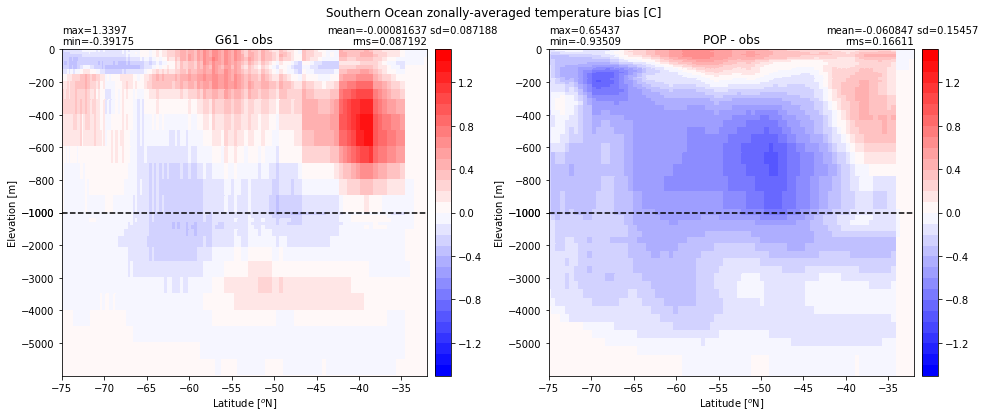

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Southern Ocean zonally-averaged temperature bias [C]')
yzplot(np.ma.masked_invalid(mom_temp_so.transpose()), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-1.5, 1.5), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(-75,-32)
yzplot(np.ma.masked_invalid(pop_temp_so), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$N', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-1.5,1.5), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(-75,-32)

(-75, -32)

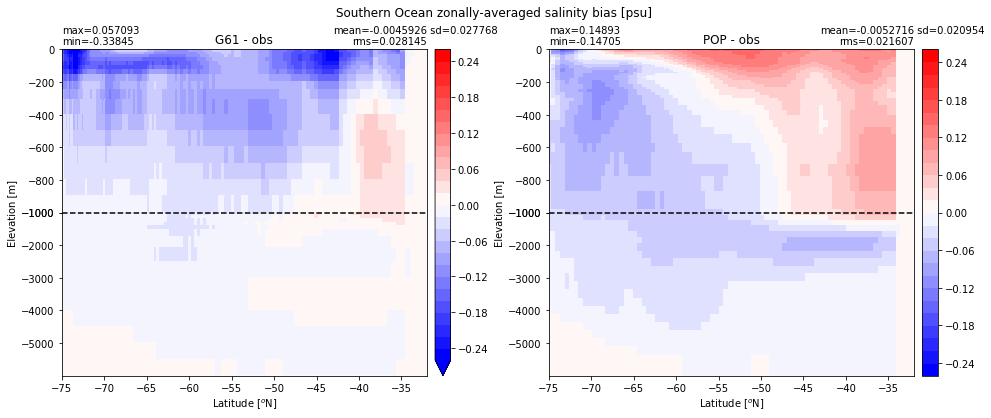

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Southern Ocean zonally-averaged salinity bias [psu]')
yzplot(np.ma.masked_invalid(mom_salt_so.transpose()), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-0.25, 0.25), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(-75,-32)
yzplot(np.ma.masked_invalid(pop_salt_so), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$N', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-0.25, 0.25), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(-75,-32)

### Indian Ocean

In [28]:
# POP
# mask #3
mask_pop_io = (grid.REGION_MASK.where(grid.REGION_MASK==3)/3.).rename({'nlon': 'xh','nlat': 'yh'})
pop_temp_io = ((pop_temp_bias * area_pop * mask_pop_io).sum('xh')/area_pop.sum('xh'))
pop_salt_io = ((pop_salt_bias * area_pop * mask_pop_io).sum('xh')/area_pop.sum('xh'))

# MOM
mom_temp_io = ((basin_code.sel(region='IndianOcean')*mom_temp_bias * area_mom).sum('xh')/area_mom.sum('xh'))
mom_salt_io = ((basin_code.sel(region='IndianOcean')*mom_salt_bias * area_mom).sum('xh')/area_mom.sum('xh'))

(-40, 30)

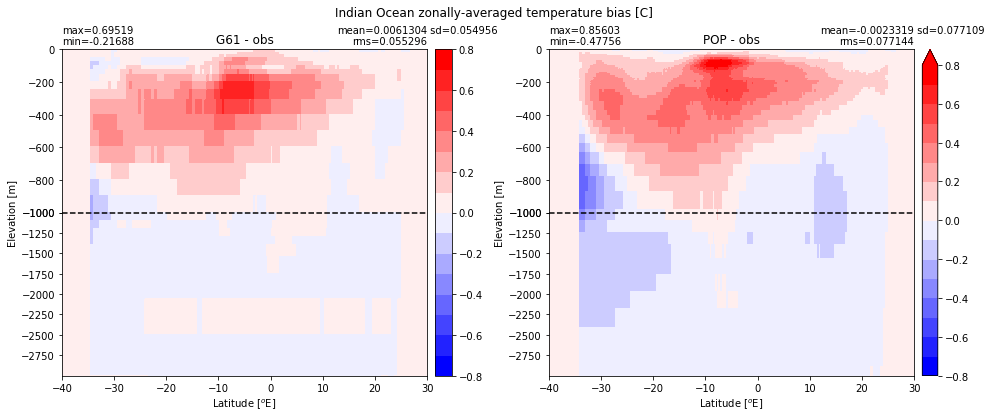

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Indian Ocean zonally-averaged temperature bias [C]')
yzplot(np.ma.masked_invalid(mom_temp_io.transpose()), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$E', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-0.8, 0.8), centerlabels=True, splitscale=[0, -1000,-3000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(-40,30)
yzplot(np.ma.masked_invalid(pop_temp_io), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$E', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-0.8, 0.8), centerlabels=True, splitscale=[0, -1000,-3000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(-40,30)

(-40, 30)

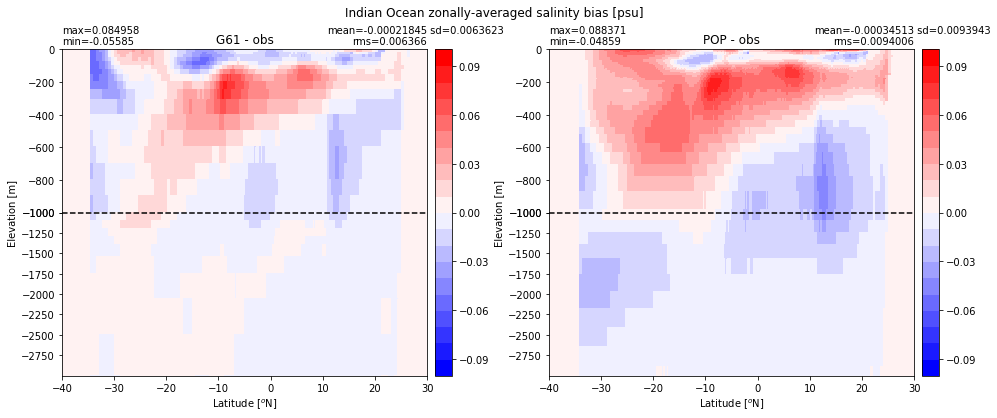

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Indian Ocean zonally-averaged salinity bias [psu]')
yzplot(np.ma.masked_invalid(mom_salt_io.transpose()), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-0.1, 0.1), centerlabels=True, splitscale=[0, -1000,-3000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(-40,30)
yzplot(np.ma.masked_invalid(pop_salt_io), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$N', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-0.1, 0.1), centerlabels=True, splitscale=[0, -1000,-3000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(-40,30)

### Med Sea

In [31]:
# POP
# mask #7
mask_pop_med = (grid.REGION_MASK.where(grid.REGION_MASK==7)/7.).rename({'nlon': 'xh','nlat': 'yh'})
pop_temp_med = ((pop_temp_bias * area_pop * mask_pop_med).sum('xh')/area_pop.sum('xh'))
pop_salt_med = ((pop_salt_bias * area_pop * mask_pop_med).sum('xh')/area_pop.sum('xh'))

# MOM
mom_temp_med = ((basin_code.sel(region='MedSea')*mom_temp_bias * area_mom).sum('xh')/area_mom.sum('xh'))
mom_salt_med = ((basin_code.sel(region='MedSea')*mom_salt_bias * area_mom).sum('xh')/area_mom.sum('xh'))

(30, 48)

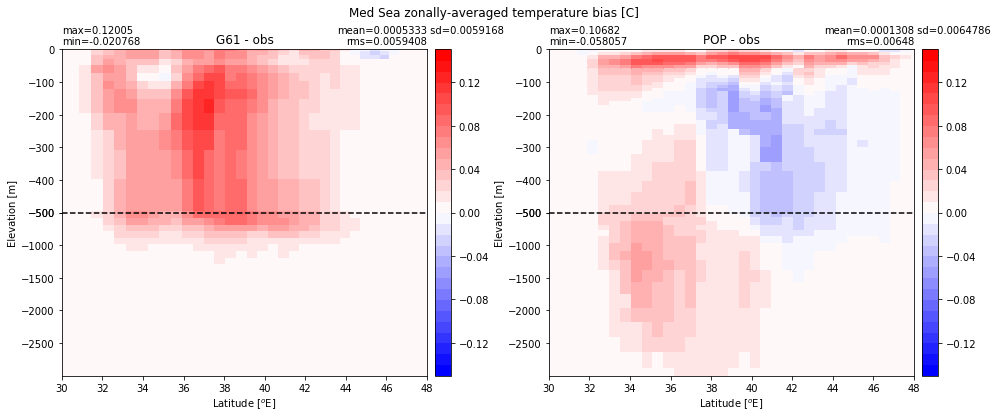

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Med Sea zonally-averaged temperature bias [C]')
yzplot(np.ma.masked_invalid(mom_temp_med.transpose()), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$E', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-0.15, 0.15), centerlabels=True, splitscale=[0, -500,-3000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(30,48)
yzplot(np.ma.masked_invalid(pop_temp_med), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$E', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-0.15, 0.15), centerlabels=True, splitscale=[0, -500,-3000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(30,48)

(30, 48)

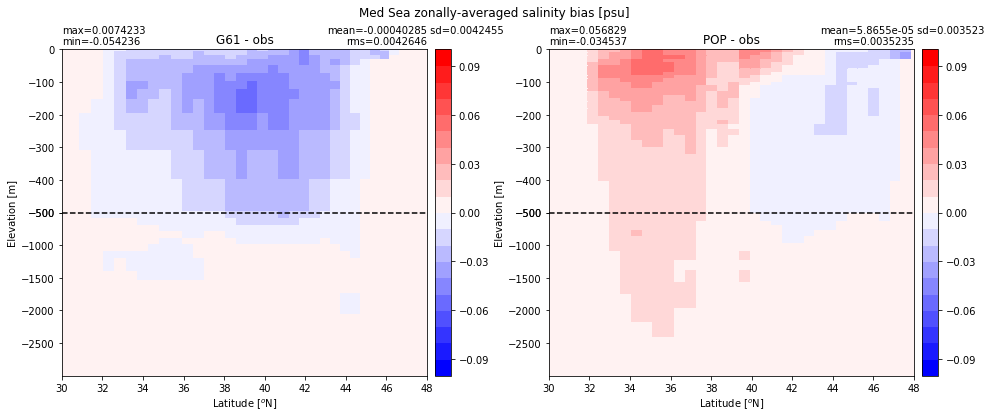

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Med Sea zonally-averaged salinity bias [psu]')
yzplot(np.ma.masked_invalid(mom_salt_med.transpose()), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-0.1, 0.1), centerlabels=True, splitscale=[0, -500,-3000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(30,48)
yzplot(np.ma.masked_invalid(pop_salt_med), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$N', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-0.1, 0.1), centerlabels=True, splitscale=[0, -500,-3000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(30,48)

### Arctic Ocean

In [34]:
# POP
# combine masks #9 and #10
tmp = np.zeros(grid.REGION_MASK.shape)
tmp[grid.REGION_MASK.values == 9] = 1.0
tmp[grid.REGION_MASK.values == 10] = 1.0
mask_pop_arc = xr.DataArray(tmp, dims=('yh','xh'), 
                             coords={'yh': ds_pop_t.yh, 'xh':ds_pop_t.xh})

pop_temp_arc = ((pop_temp_bias * area_pop * mask_pop_arc).sum('xh')/area_pop.sum('xh'))
pop_salt_arc = ((pop_salt_bias * area_pop * mask_pop_arc).sum('xh')/area_pop.sum('xh'))

# MOM
mom_temp_arc = ((basin_code.sel(region='Arctic')*mom_temp_bias * area_mom).sum('xh')/area_mom.sum('xh'))
mom_salt_arc = ((basin_code.sel(region='Arctic')*mom_salt_bias * area_mom).sum('xh')/area_mom.sum('xh'))

(60, 90)

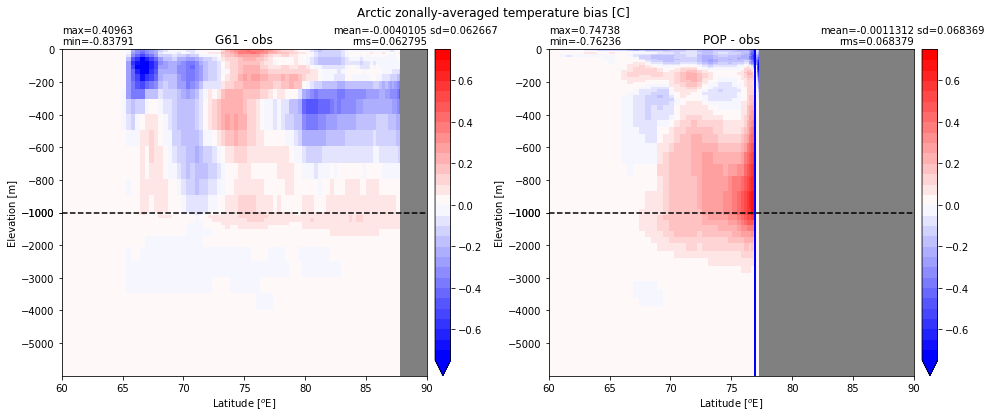

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Arctic zonally-averaged temperature bias [C]')
yzplot(np.ma.masked_invalid(mom_temp_arc.transpose()), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$E', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-0.75, 0.75), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(60,90)
yzplot(np.ma.masked_invalid(pop_temp_arc), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$E', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-0.75,0.75), centerlabels=True, splitscale=[0, -1000,-6000]) 
ax1[1].invert_yaxis(); ax1[1].set_xlim(60,90)

(60, 90)

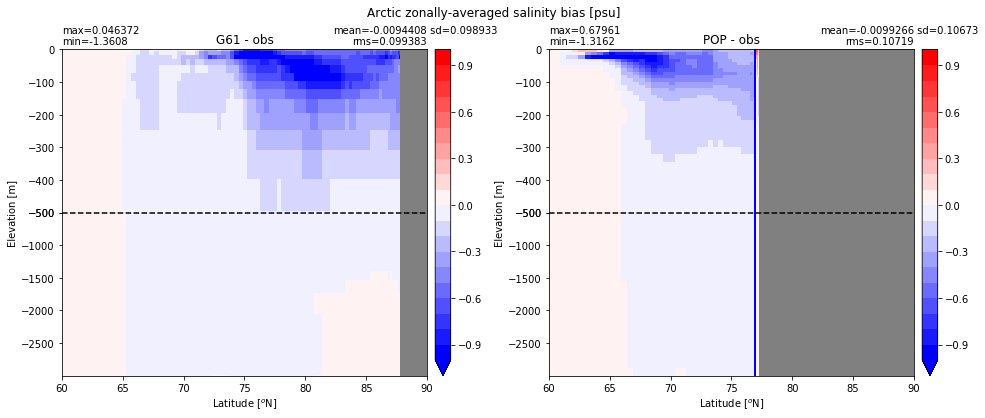

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Arctic zonally-averaged salinity bias [psu]')
yzplot(np.ma.masked_invalid(mom_salt_arc.transpose()), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-1, 1), centerlabels=True, splitscale=[0, -500,-3000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(60,90)
yzplot(np.ma.masked_invalid(pop_salt_arc), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$N', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-1, 1), centerlabels=True, splitscale=[0, -500,-3000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(60,90)

# Equatorial plots

### Temperature and Salinity

<center> <font size="4">Equatorial_Global_temperature</font></center>
<table><tr>
    <td><img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.061_Equatorial_Global_temperature.png'></td>
    <td>
    <img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.061_Equatorial_Global_salinity.png'></td>
    </tr>          
</table>

## Undercurrent

<center> <font size="4">Equatorial_Pacific_uo</font></center>
<table><tr><td><img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.061_Equatorial_Pacific_uo.png'></td></tr>
</table>

# Horizontal Mean bias (w.r.t. obs) versus time

In [37]:
i=0
ds_mom = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_temp_bias.nc')
ds_mom.region

<xarray.DataArray 'region' (region: 11)>
array(['Global', 'MedSea', 'BalticSea', 'HudsonBay', 'Arctic', 'PacificOcean',
       'AtlanticOcean', 'IndianOcean', 'SouthernOcean', 'LabSea', 'BaffinBay'],
      dtype=object)
Coordinates:
  * region   (region) object 'Global' 'MedSea' ... 'LabSea' 'BaffinBay'

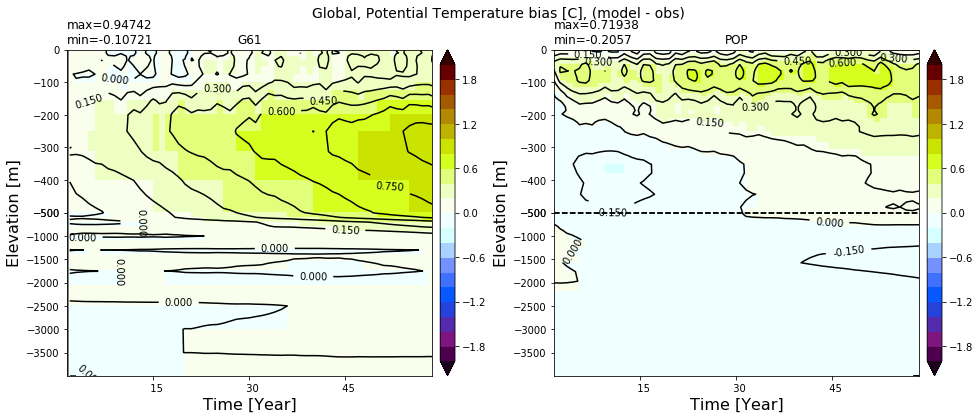

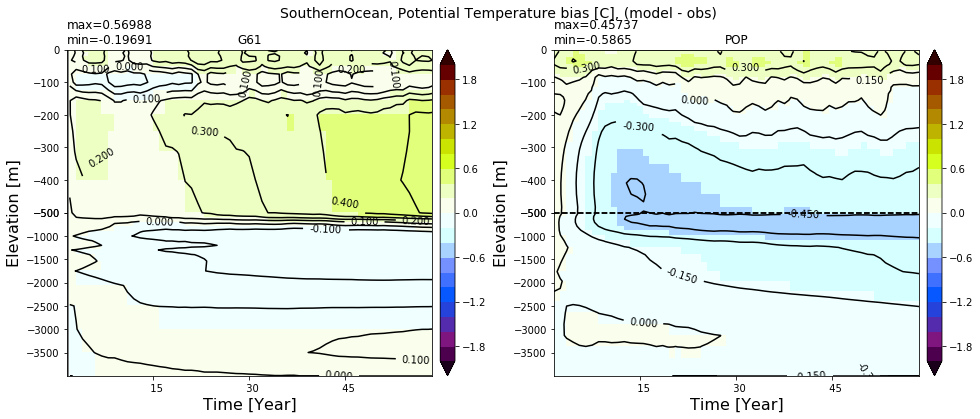

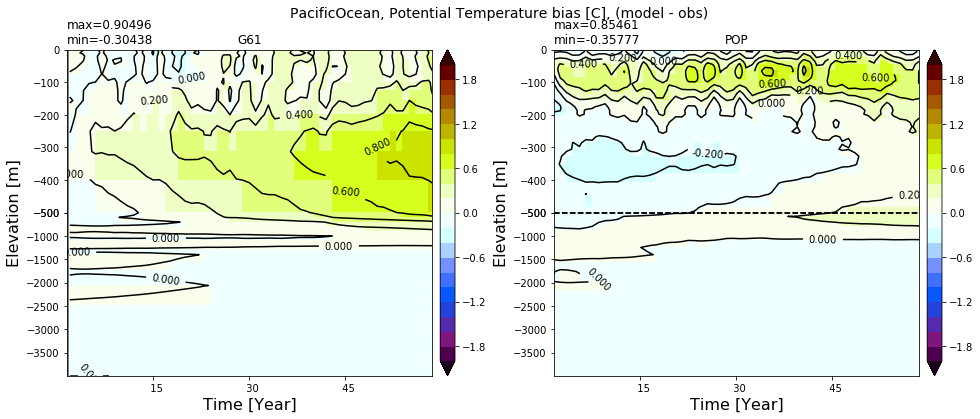

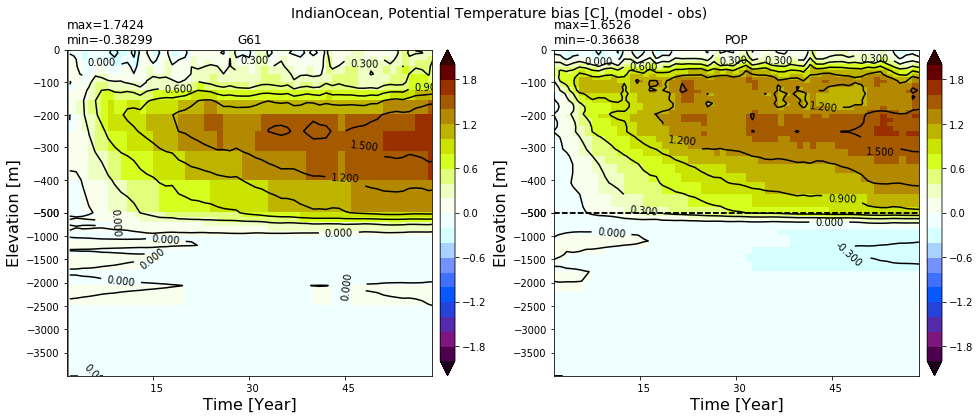

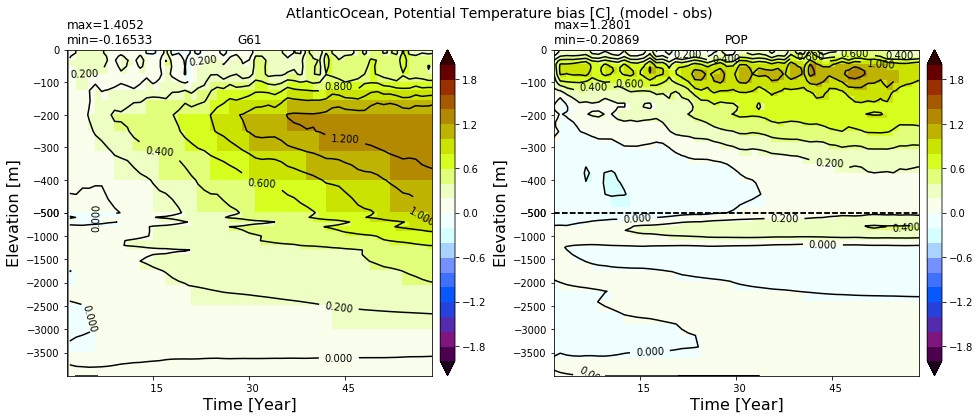

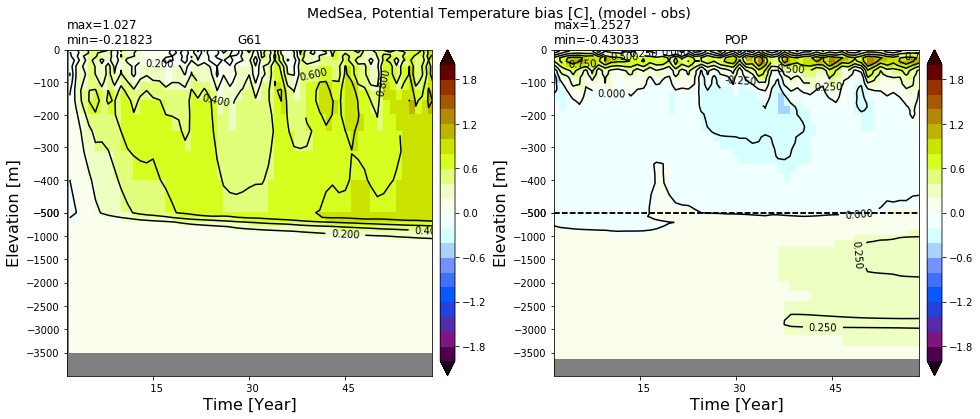

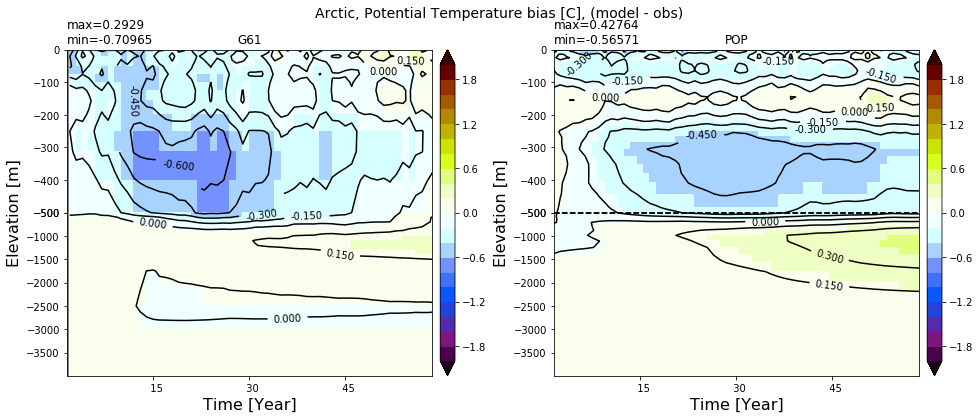

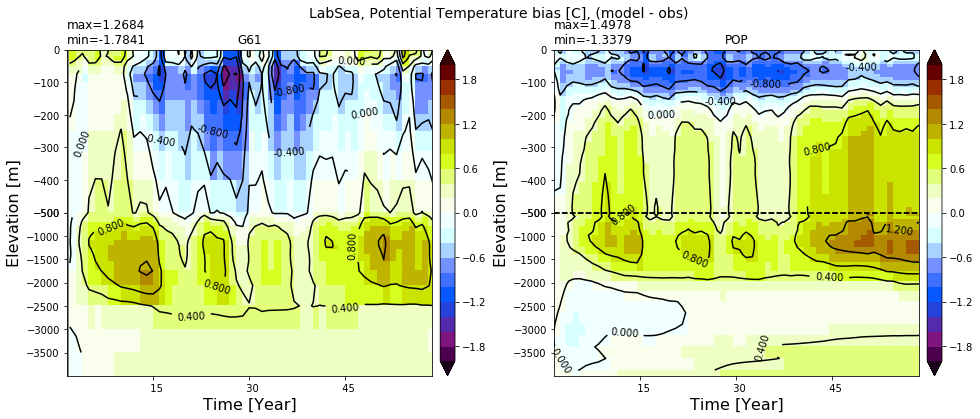

In [38]:
%matplotlib inline
reg_mom = ['Global','SouthernOcean','PacificOcean','IndianOcean','AtlanticOcean','MedSea','Arctic','LabSea']
reg_pop = [0,1,2,3,6,7,10,8]

ds_mom = xr.open_dataset('../../'+exps[0]+'/ncfiles/'+exps[0]+'_temp_bias.nc').sel(time=slice('0001-01-01', '0059-01-01'))
ds_pop = xr.open_dataset('/glade/scratch/gmarques/g210.GIAF_JRA.v13.gx1v7.01_temp_bias.nc').sel(time=slice('0001-01-01', '0059-01-01'))
    
for m,p in zip(reg_mom,reg_pop):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
  plt.suptitle(str(m)+', Potential Temperature bias [C], (model - obs)', fontsize=14)
  splitscale =  [0., -500., -4000]
  dummy_mom = np.ma.masked_invalid(ds_mom.sel(region=m).__xarray_dataarray_variable__.values)
  dummy_pop = np.ma.masked_invalid(ds_pop.__xarray_dataarray_variable__.sel(region=str(p)).values)

  dummy_pop = np.ma.masked_invalid(ds_pop.sel(region=str(p)).__xarray_dataarray_variable__.values)

  ztplot(dummy_mom, ds_mom.time.values, ds_mom.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[0] ,
           title=labels[0], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-2, 2)) 
  ztplot(dummy_pop, ds_pop.time.values, -ds_pop.z_l.values/100., ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[1] ,
           title='POP', extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-2, 2))  

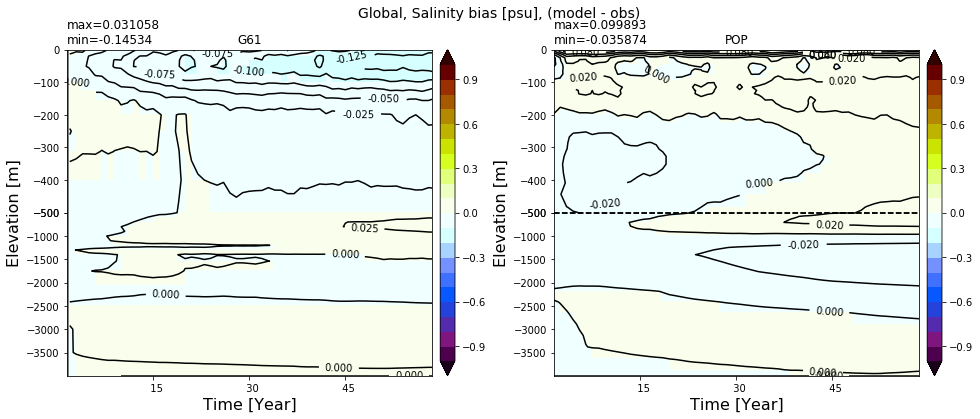

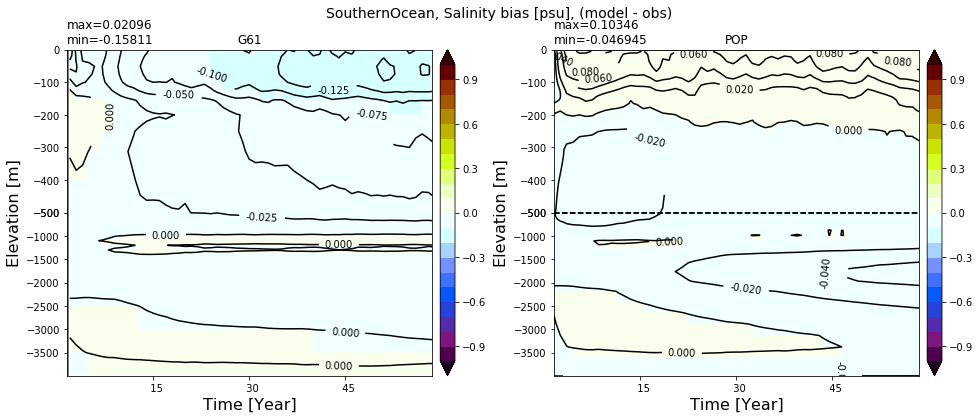

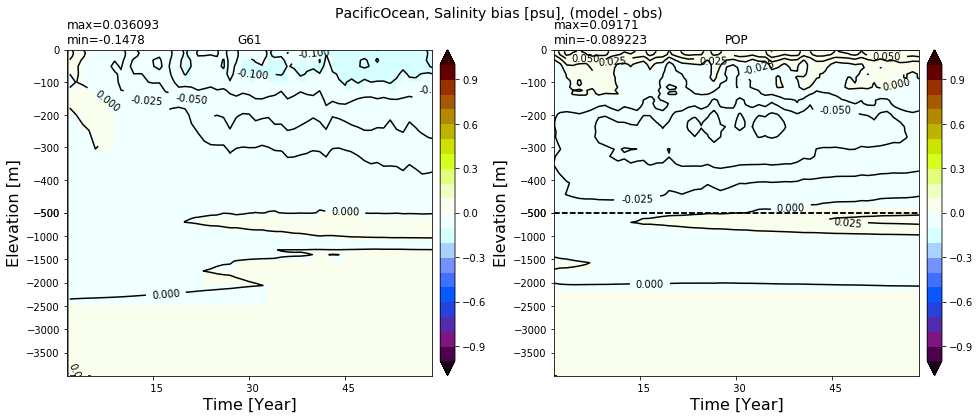

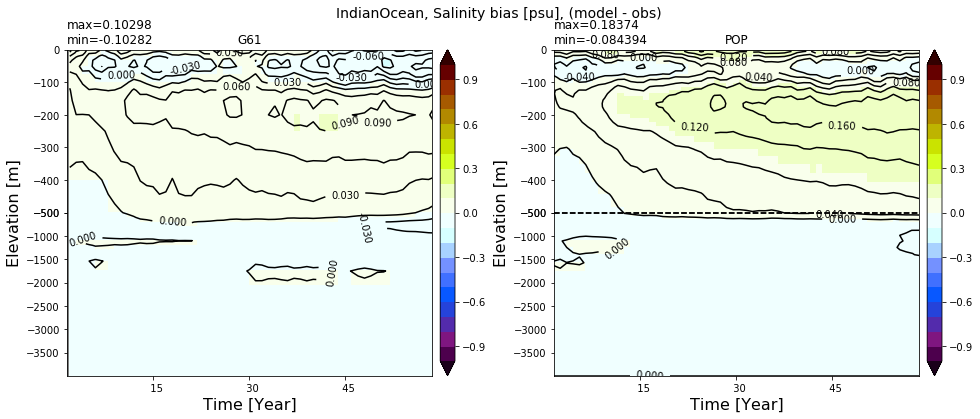

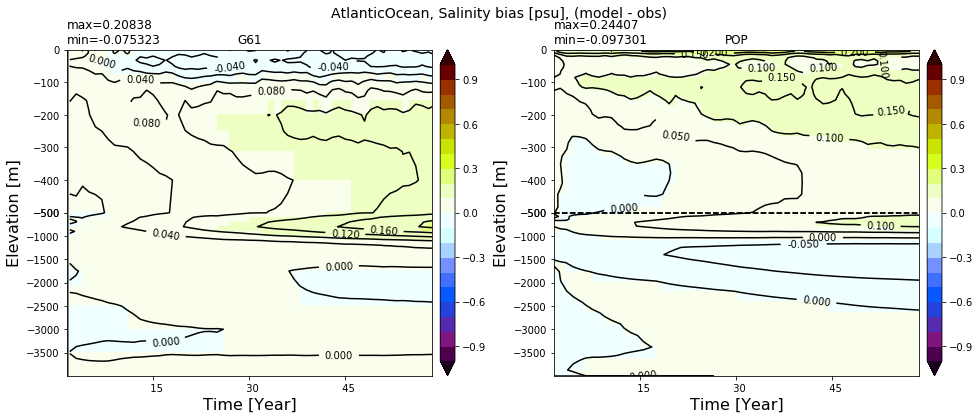

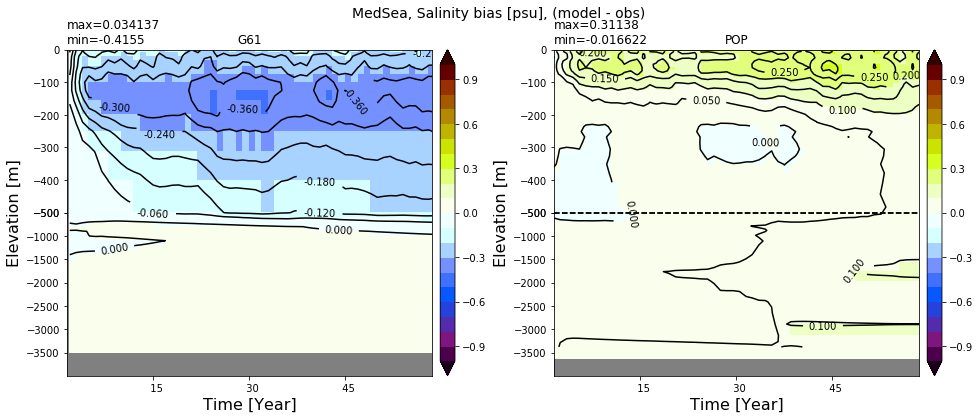

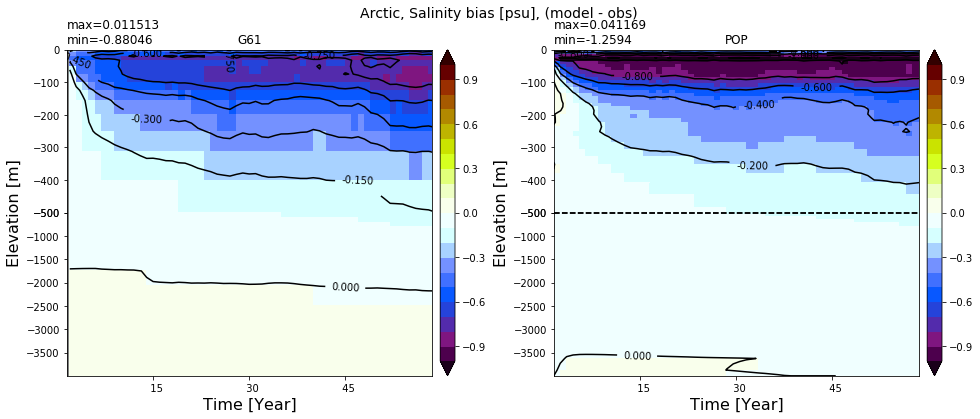

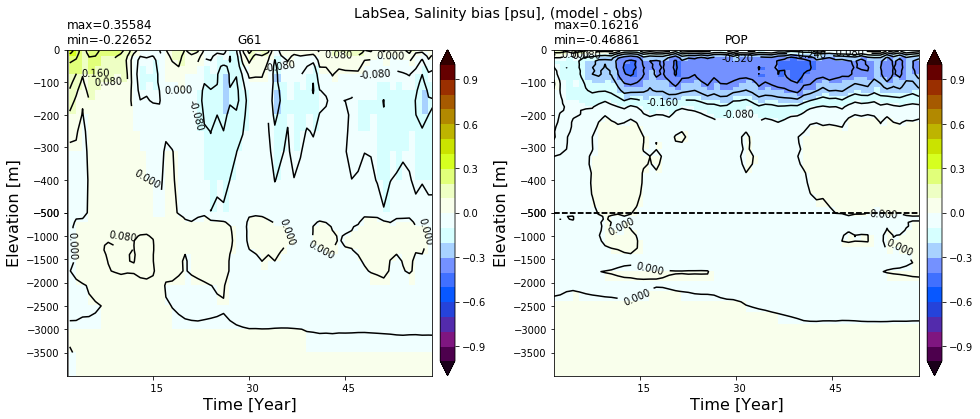

In [39]:
%matplotlib inline

ds_mom = xr.open_dataset('../../'+exps[0]+'/ncfiles/'+exps[0]+'_salt_bias.nc').sel(time=slice('0001-01-01', '0059-01-01'))
ds_pop = xr.open_dataset('/glade/scratch/gmarques/g210.GIAF_JRA.v13.gx1v7.01_salt_bias.nc').sel(time=slice('0001-01-01', '0059-01-01'))
        
for m,p in zip(reg_mom,reg_pop):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
  plt.suptitle(str(m)+', Salinity bias [psu], (model - obs)', fontsize=14)
  splitscale =  [0., -500., -4000]
  dummy_mom = np.ma.masked_invalid(ds_mom.sel(region=m).__xarray_dataarray_variable__.values)
  dummy_pop = np.ma.masked_invalid(ds_pop.__xarray_dataarray_variable__.sel(region=str(p)).values)

  dummy_pop = np.ma.masked_invalid(ds_pop.sel(region=str(p)).__xarray_dataarray_variable__.values)

  ztplot(dummy_mom, ds_mom.time.values, ds_mom.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[0] ,
           title=labels[0], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-1, 1)) 
  ztplot(dummy_pop, ds_pop.time.values, -ds_pop.z_l.values/100., ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[1] ,
           title='POP', extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-1, 1))  

# Mixing coefficients

In [40]:
def get_data_sf(full_path):
  ds = xr.open_dataset(full_path)
  return ds
variables = ['diftrblo', 'difmxylo' ,'difmxybo', 'diftrelo']

## GM (KHTH)

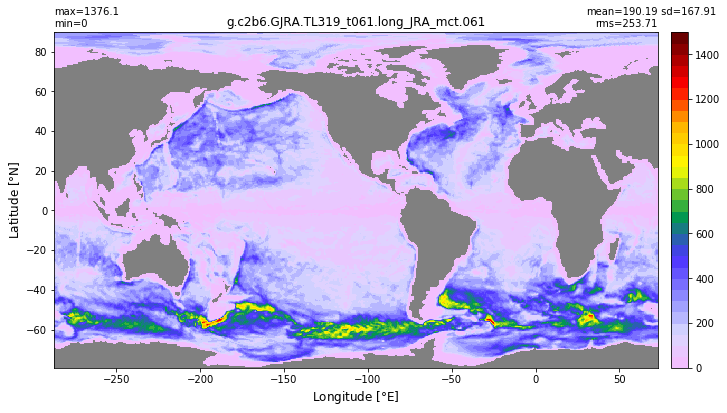

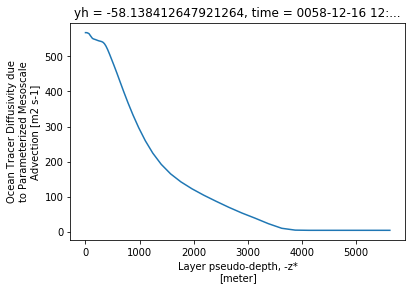

In [41]:
# GM coefficient
# find point in the Drake Passage
j = np.abs( grd.geolat[:,0] - -58.0 ).argmin()
i = np.abs( grd.geolon[0,:] - -58.0 ).argmin()
for exp in range(len(exps)):
  ds = get_data_sf(path+exps[exp]+'/run/'+exps[exp]+'.mom6.hm_0058_12.nc')
  xyplot(np.ma.masked_invalid(ds[variables[0]][0,0,:].values), grd.geolon, grd.geolat, area=grd.area_t, 
         clim=(0,1500), title=str(exps[exp]))
  f, ax = plt.subplots(1,1)
  ds[variables[0]][0,:,j,i].plot(ax=ax)


## Laplacian viscosity

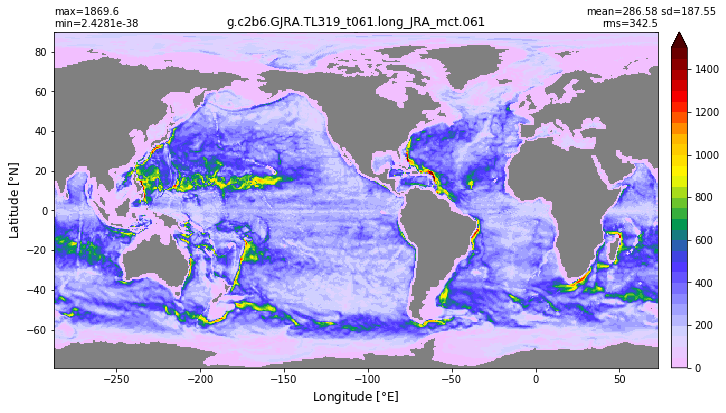

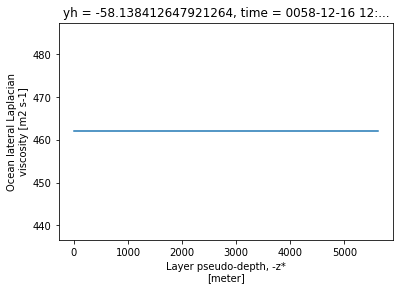

In [42]:
# Laplacian visc
# find point in the Drake Passage
j = np.abs( grd.geolat[:,0] - -58.0 ).argmin()
i = np.abs( grd.geolon[0,:] - -58.0 ).argmin()
for exp in range(len(exps)):
  ds = get_data_sf(path+exps[exp]+'/run/'+exps[exp]+'.mom6.hm_0058_12.nc')
  xyplot(np.ma.masked_invalid(ds[variables[1]][0,0,:].values), grd.geolon, grd.geolat, area=grd.area_t, clim=(0,1500), title=str(exps[exp]))
  f, ax = plt.subplots(1,1)
  ds[variables[1]][0,:,j,i].plot(ax=ax)

## Biharmonic viscosity

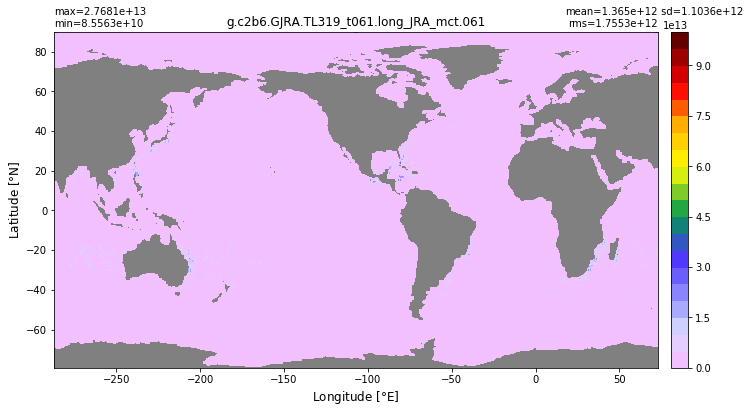

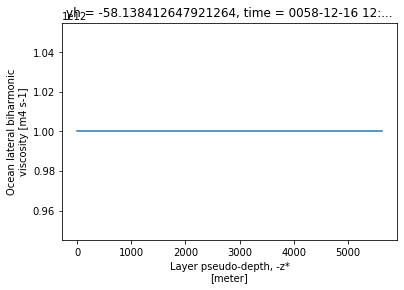

In [43]:
# Biharmonic
# find point in the Drake Passage
j = np.abs( grd.geolat[:,0] - -58.0 ).argmin()
i = np.abs( grd.geolon[0,:] - -58.0 ).argmin()
for exp in range(len(exps)):
  ds = get_data_sf(path+exps[exp]+'/run/'+exps[exp]+'.mom6.hm_0058_12.nc')
  xyplot(np.ma.masked_invalid(ds[variables[2]][0,0,:].values), grd.geolon, grd.geolat, area=grd.area_t, clim=(1.0e10,1.0e14), title=str(exps[exp]))
  f, ax = plt.subplots(1,1)
  ds[variables[2]][0,:,j,i].plot(ax=ax)

## Redi (KHTR)

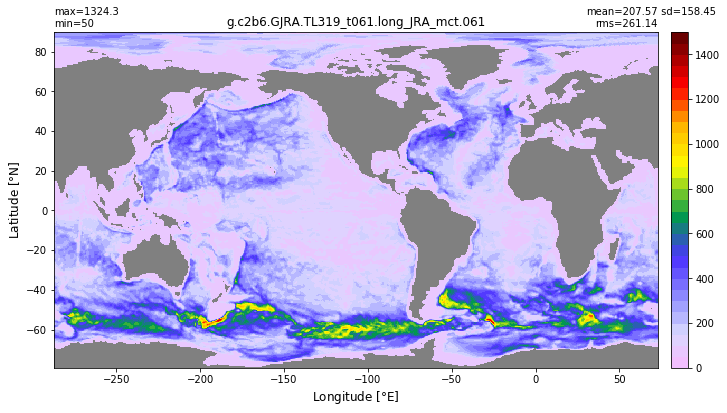

In [44]:
# KHTR (Redi)
# find point in the Drake Passage
j = np.abs( grd.geolat[:,0] - -58.0 ).argmin()
i = np.abs( grd.geolon[0,:] - -58.0 ).argmin()
for exp in range(len(exps)):
  ds = get_data_sf(path+exps[exp]+'/run/'+exps[exp]+'.mom6.hm_0058_12.nc')
  xyplot(np.ma.masked_invalid(ds[variables[3]][0,:].values), grd.geolon, grd.geolat, clim=(0, 1500), area=grd.area_t, title=str(exps[exp]))